In [2]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import pdb
import requests
import matplotlib.pyplot as plt
from collections import defaultdict
import random 
import time

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import *

from functools import wraps
from time import time as _timenow 
from sys import stderr

## Load CIFAR-10 Data

In [3]:
def load_cifar():
    
    trn_data, trn_labels, tst_data, tst_labels = [], [], [], []
    def unpickle(file):
        with open(file, 'rb') as fo:
            data = pickle.load(fo, encoding='latin1')
        return data
    
    for i in trange(1):
        batchName = './data/data_batch_{0}'.format(i + 1)
        unpickled = unpickle(batchName)
        trn_data.extend(unpickled['data'])
        trn_labels.extend(unpickled['labels'])
    unpickled = unpickle('./data/test_batch')
    tst_data.extend(unpickled['data'])
    tst_labels.extend(unpickled['labels'])
    return trn_data, trn_labels, tst_data, tst_labels

## Image preprocessing

In [4]:
def image_prep(image):
    processed_image = image
#     processed_image = processed_image/sd
    ''' pre-processes the given image
        performs mean normalization and other such operations'''
    return processed_image

## Dimensionality reduction using PCA

In [5]:
def reduce_dim(**kwargs):
    dim = kwargs['dim']
    train_X = kwargs['train_X']
    train_y = kwargs['train_y']
    ''' performs dimensionality reduction'''
    if kwargs['method'] == 'pca':
        pca = PCA(n_components=dim)
        pca.fit(train_X)
        X_reduced = pca.transform(train_X)
        return pca, X_reduced
    
    if kwargs['method'] == 'lda':
        lda = LinearDiscriminantAnalysis(n_components=dim)
        lda.fit(train_X,train_y)
        X_reduced = lda.transform(train_X)
        return lda, X_reduced
    
    if kwargs['method'] == 'kpca':
        kpca = KernelPCA(n_components=dim, kernel='rbf',n_jobs = -1)
        X_reduced = kpca.fit_transform(train_X)
        return kpca, X_reduced

## Classification using kernel SVM

In [6]:
def classify(X, y, **kwargs):
    ''' trains a classifier by taking input features
        and their respective targets and returns the trained model'''
    if kwargs['method'] == 'Logistic Regression':
        clf = LogisticRegression()
        clf = clf.fit(X, y)
        return clf
    if kwargs['method'] == 'Decision Tree':
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(X, y)
        return clf
    if kwargs['method'] == 'Kernel SVM':
        clf = svm.SVC(gamma='scale',kernel='rbf')
        clf = clf.fit(X, y)
        return clf
        

## Evaluation 

In [7]:
def evaluate(target, predicted):
    f1 = f1_score(target, predicted, average='micro')
    acc = accuracy_score(target, predicted)
    return f1, acc

In [8]:
def test(**kwargs):
    classifer_model = kwargs['classifer_model']
    test_X = kwargs['test_X']
    test_y = kwargs['test_y']
    predicted_y = classifer_model.predict(test_X)
    f1, acc = evaluate(test_y, predicted=predicted_y)
    print(f1)
#     print(acc)
    return f1, acc

In [10]:
svm_PCA_acc = []
svm_PCA_f1 = []
def main1():
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    trn_data, tst_data = list(map(image_prep, trn_data)), list(map(image_prep, tst_data))
    X_train, X_val, y_train, y_val = train_test_split(trn_data, trn_labels,test_size = 0.20)
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
    X_train = scaling.transform(X_train)
    X_val = scaling.transform(X_val)
    dims=[1,2,4,8,16,32,64,128,256,512,1024]
    for dim in dims:
        print(dim)
        reduced_model, X_reduced = reduce_dim(method='kpca',dim=dim,train_X = X_train,train_y = y_train)
        classifer_model = classify(X_reduced, y_train, method='Kernel SVM')
        test_X_reduced = reduced_model.transform(X_val)
        f1, acc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
        svm_PCA_acc.append(acc)
        svm_PCA_f1.append(f1)
main1()
#     print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy_))


100%|██████████| 1/1 [00:00<00:00, 29.30it/s]


1
0.169
2
0.20999999999999996
4
0.266
8
0.321
16
0.3575
32
0.3775
64
0.37050000000000005
128
0.37050000000000005
256
0.3565
512
0.346
1024
0.325


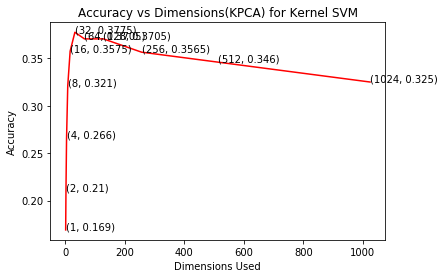

In [11]:
dims=[1,2,4,8,16,32,64,128,256,512,1024]
for i in range(1,len(svm_PCA_acc)):
#     print(i)
    svm_PCA_f1[i] = round(svm_PCA_f1[i], 3)
#     print(i)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(dims,svm_PCA_acc,'r')
plt.xlabel('Dimensions Used')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dimensions(KPCA) for Kernel SVM')
for xy in zip(dims, svm_PCA_acc):
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.savefig('finalkernelsvm_KPCA_accuracy_2.svg',format='svg')

In [12]:
print(dims)
data = {'Dimensions' : dims,
        'Accuracy':svm_PCA_acc,
#         'Score':svm_PCA_f1
       }
p = pd.DataFrame(data)

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


In [13]:
columnsTitles=["Dimensions","Accuracy"]
p = p.reindex(columns=columnsTitles)
p.index = range(1,12)
# print(p)
# print(svm_PCA_f1)
p

,Dimensions,Accuracy
1,1,0.1690
2,2,0.2100
3,4,0.2660
4,8,0.3210
5,16,0.3575
6,32,0.3775
7,64,0.3705
8,128,0.3705
9,256,0.3565
10,512,0.3460


In [9]:
def sethyperparam(X, y, **kwargs):
     if kwargs['method'] == 'Kernel SVM':
            C = kwargs['C']
            gamma = kwargs['gamma']
            clf = svm.SVC(C = C, gamma=gamma,kernel='rbf')
            clf = clf.fit(X, y)
            return clf

In [10]:
trn_data, trn_labels, tst_data, tst_labels = load_cifar()
trn_data, tst_data = list(map(image_prep, trn_data)), list(map(image_prep, tst_data))
X_train, X_val, y_train, y_val = train_test_split(trn_data, trn_labels,test_size = 0.20)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_val = scaling.transform(X_val)
tst_data = scaling.transform(tst_data)
 
reduced_model, X_reduced = reduce_dim(method='kpca',dim=32,train_X = X_train,train_y = y_train)
test_X_reduced = reduced_model.transform(X_val)
reducedtestdata = reduced_model.transform(tst_data)

100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


In [11]:
C_range = [0.5, 1, 5, 10]
gamma_range = [0.0005, 0.001, 0.01, 0.1, 0.5]
svm_PCA_acc1 = []
svm_PCA_f11 = []
def main2():
    for C in C_range:
        for gamma in gamma_range:
            print(C, gamma)
            classifer_model = sethyperparam(X_reduced, y_train, method='Kernel SVM', gamma=gamma, C=C)
            testf1, testacc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
            trainf1, trainacc = test(classifer_model=classifer_model,test_X = X_reduced, test_y = y_train)
            svm_PCA_acc1.append(testacc)
            svm_PCA_f11.append(trainacc)

In [12]:
main2()

0.5 0.0005
0.10149999999999999
0.10362499999999998
0.5 0.001
0.10149999999999999
0.10362499999999998
0.5 0.01
0.171
0.15575
0.5 0.1
0.329
0.335625
0.5 0.5
0.3755
0.395625
1 0.0005
0.10149999999999999
0.10362499999999998
1 0.001
0.10149999999999999
0.10362499999999998
1 0.01
0.22400000000000003
0.2255
1 0.1
0.3505
0.362125
1 0.5
0.3885
0.419
5 0.0005
0.10149999999999999
0.10362499999999998
5 0.001
0.171
0.155625
5 0.01
0.3325
0.336
5 0.1
0.383
0.40775
5 0.5
0.40700000000000003
0.47225
10 0.0005
0.1705
0.155625
10 0.001
0.2245
0.226875
10 0.01
0.35
0.36250000000000004
10 0.1
0.3835
0.41537500000000005
10 0.5
0.42299999999999993
0.501


In [13]:
temp_C = []
temp_gamma = []
for i in range(len(C_range)):
    for j in range (len(gamma_range)):
        temp_C.append(C_range[i])
        temp_gamma.append(gamma_range[j])  

In [14]:
print(temp_C)
print(temp_gamma)
print(svm_PCA_acc1)
print(svm_PCA_f11)

[0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10]
[0.0005, 0.001, 0.01, 0.1, 0.5, 0.0005, 0.001, 0.01, 0.1, 0.5, 0.0005, 0.001, 0.01, 0.1, 0.5, 0.0005, 0.001, 0.01, 0.1, 0.5]
[0.1015, 0.1015, 0.171, 0.329, 0.3755, 0.1015, 0.1015, 0.224, 0.3505, 0.3885, 0.1015, 0.171, 0.3325, 0.383, 0.407, 0.1705, 0.2245, 0.35, 0.3835, 0.423]
[0.103625, 0.103625, 0.15575, 0.335625, 0.395625, 0.103625, 0.103625, 0.2255, 0.362125, 0.419, 0.103625, 0.155625, 0.336, 0.40775, 0.47225, 0.155625, 0.226875, 0.3625, 0.415375, 0.501]


In [15]:
data1 = {'C' : temp_C,
         'Gamma' : temp_gamma,
         'Test Accuracy' : svm_PCA_acc1,
         'Train Accuracy' : svm_PCA_f11
#         'Score':svm_PCA_f1
       }
p1 = pd.DataFrame(data1)
columnsTitles=["C","Gamma", "Test Accuracy", "Train Accuracy"]
p1 = p1.reindex(columns=columnsTitles)
p1.index = range(1,21)
p1

,C,Gamma,Test Accuracy,Train Accuracy
1,0.5,0.0005,0.1015,0.103625
2,0.5,0.0010,0.1015,0.103625
3,0.5,0.0100,0.1710,0.155750
4,0.5,0.1000,0.3290,0.335625
5,0.5,0.5000,0.3755,0.395625
6,1.0,0.0005,0.1015,0.103625
7,1.0,0.0010,0.1015,0.103625
8,1.0,0.0100,0.2240,0.225500
9,1.0,0.1000,0.3505,0.362125
10,1.0,0.5000,0.3885,0.419000


In [25]:
classifer_model1 = sethyperparam(X_reduced, y_train, method='Kernel SVM', gamma=1, C=100)
testf1, testacc = test(classifer_model=classifer_model1,test_X = test_X_reduced, test_y = y_val)
test(classifer_model=classifer_model1,test_X = reducedtestdata, test_y = tst_labels)


0.4475
0.4556


(0.4556, 0.4556)